In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
tech = ['AAPL','MSFT','INTC','QCOM','GLOB','IBM','ADBE','NVDA','CSCO','TGT','HPQ']

In [3]:
df = yahoo.download(tech,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  11 of 11 completed


AAPL   NaN
ADBE   NaN
CSCO   NaN
GLOB   NaN
HPQ    NaN
IBM    NaN
INTC   NaN
MSFT   NaN
NVDA   NaN
QCOM   NaN
TGT    NaN
dtype: float64

In [4]:
df

,AAPL,ADBE,CSCO,GLOB,HPQ,IBM,INTC,MSFT,NVDA,QCOM,TGT
Datetime,,,,,,,,,,,
2019-08-14 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-15 09:30:00-04:00,202.559998,283.355011,47.164101,100.349998,18.780001,131.350006,45.849998,133.395004,149.380005,71.959999,82.699997
2019-08-15 10:30:00-04:00,201.270004,282.859985,46.945000,100.040604,18.670000,131.309998,45.840000,133.292694,148.270004,71.620003,83.010002
2019-08-15 11:30:00-04:00,201.910004,282.589996,46.794998,100.370003,18.629999,131.559601,45.849998,133.580002,148.216797,71.129997,82.680000
2019-08-15 12:30:00-04:00,202.100006,283.029999,46.505001,99.779999,18.639999,131.559998,45.820000,133.500000,148.919998,71.089996,82.570000
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-14 11:30:00-04:00,457.636902,446.549988,42.373199,175.505005,18.309999,125.239998,48.980000,208.479996,460.790009,113.809998,135.709702
2020-08-14 12:30:00-04:00,459.140015,447.769989,42.470001,174.360001,18.334999,125.305000,49.055000,208.649994,460.795013,113.809998,136.395004
2020-08-14 13:30:00-04:00,457.269989,446.690002,42.564999,175.529999,18.250000,125.280403,48.957500,208.610001,459.739990,113.595001,136.929993


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = 20
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

TGT     0.300
MSFT    0.300
AAPL    0.300
ADBE    0.145
IBM     0.144
CSCO    0.069
HPQ     0.012
QCOM   -0.027
GLOB   -0.040
NVDA   -0.093
INTC   -0.110
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


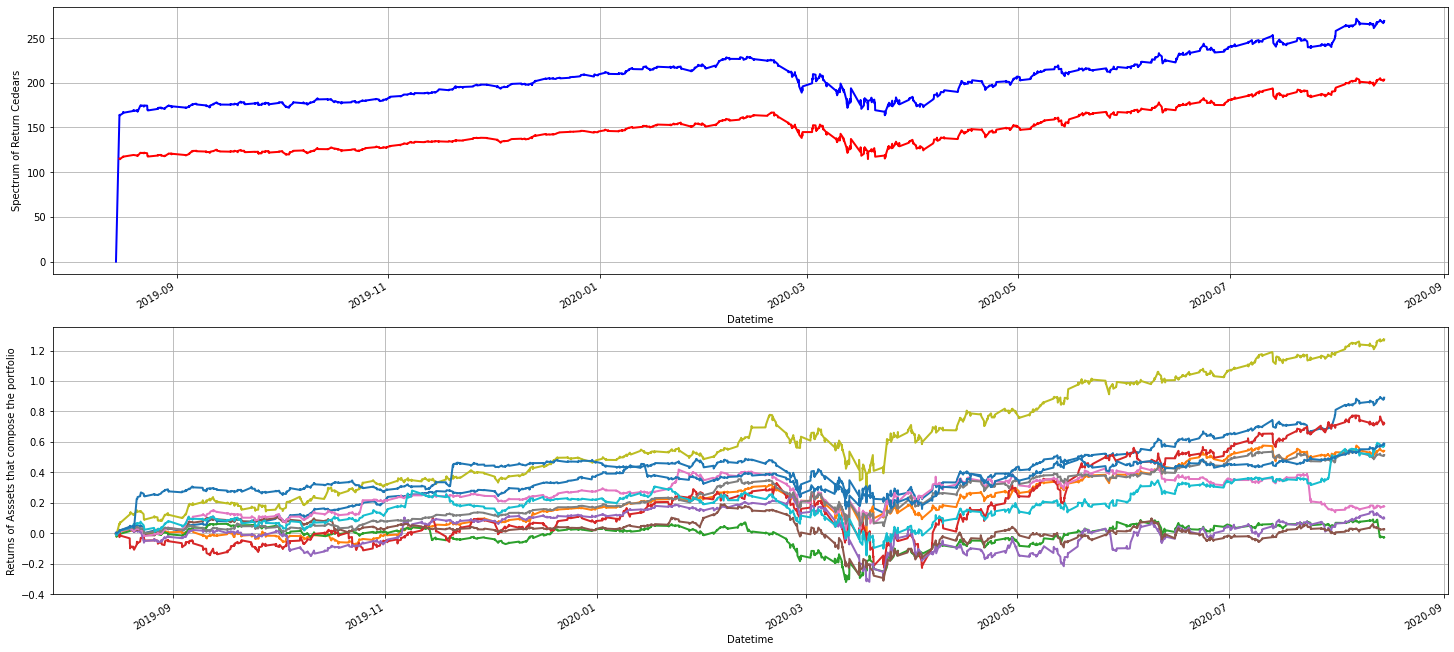

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-14 09:30:00-04:00      0.000000
 2019-08-15 09:30:00-04:00    164.184300
 2019-08-15 10:30:00-04:00    163.891518
 2019-08-15 11:30:00-04:00    164.060577
 2019-08-15 12:30:00-04:00    164.067127
                                 ...    
 2020-08-14 11:30:00-04:00    268.141418
 2020-08-14 12:30:00-04:00    269.079266
 2020-08-14 13:30:00-04:00    268.579999
 2020-08-14 14:30:00-04:00    268.032165
 2020-08-14 15:30:00-04:00    269.175499
 Length: 1766, dtype: float64,
 Datetime
 2019-08-14 09:30:00-04:00           NaN
 2019-08-15 09:30:00-04:00    115.167647
 2019-08-15 10:30:00-04:00    114.829845
 2019-08-15 11:30:00-04:00    114.846491
 2019-08-15 12:30:00-04:00    114.865000
                                 ...    
 2020-08-14 11:30:00-04:00    203.034981
 2020-08-14 12:30:00-04:00    203.280456
 2020-08-14 13:30:00-04:00    203.037989
 2020-08-14 14:30:00-04:00    202.748955
 2020-08-14 15:30:00-04:00    203.518181
 Length: 1766, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

TGT     0.30
MSFT    0.30
AAPL    0.30
ADBE    0.15
IBM     0.14
CSCO    0.07
HPQ     0.01
QCOM   -0.03
GLOB   -0.04
NVDA   -0.09
INTC   -0.11
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-14 09:30:00-04:00      0.000000
2019-08-15 09:30:00-04:00    165.317539
2019-08-15 10:30:00-04:00    165.020133
2019-08-15 11:30:00-04:00    165.188084
2019-08-15 12:30:00-04:00    165.198752
                                ...    
2020-08-14 11:30:00-04:00    270.919901
2020-08-14 12:30:00-04:00    271.863651
2020-08-14 13:30:00-04:00    271.356827
2020-08-14 14:30:00-04:00    270.809277
2020-08-14 15:30:00-04:00    271.964499
Length: 1766, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
AAPL,0.090909,0.677387,0.008929,0.018145,0.212622
ADBE,0.090909,0.654226,0.009712,0.019062,0.212622
CSCO,0.090909,0.600340,0.009301,0.016752,0.212622
GLOB,0.090909,0.555719,0.013797,0.023002,0.212622
HPQ,0.090909,0.525853,0.012074,0.019047,0.212622
IBM,0.090909,0.625915,0.009062,0.017016,0.212622
INTC,0.090909,0.627511,0.011213,0.021109,0.212622
MSFT,0.090909,0.700317,0.008545,0.017953,0.212622
NVDA,0.090909,0.652814,0.012721,0.024913,0.212622
QCOM,0.090909,0.620926,0.011607,0.021621,0.212622


In [15]:
poe, fullstress

(AAPL   -11.555484
 ADBE   -12.253842
 CSCO   -12.407530
 GLOB    -7.842716
 HPQ     -9.985430
 IBM    -11.745598
 INTC   -14.106290
 MSFT   -11.161362
 NVDA    -9.302759
 QCOM   -11.416950
 TGT     -8.355665
 dtype: float64,
 -2.315310868866352)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-14 09:30:00-04:00           NaN
2019-08-15 09:30:00-04:00    115.167647
2019-08-15 10:30:00-04:00    114.829845
2019-08-15 11:30:00-04:00    114.846491
2019-08-15 12:30:00-04:00    114.865000
                                ...    
2020-08-14 11:30:00-04:00    203.034981
2020-08-14 12:30:00-04:00    203.280456
2020-08-14 13:30:00-04:00    203.037989
2020-08-14 14:30:00-04:00    202.748955
2020-08-14 15:30:00-04:00    203.518181
Length: 1766, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
AAPL,0.000473,-0.019824,0.023868,0.016168,0.120469,0.010952,0.098565,0.111112
ADBE,0.000482,-0.019824,0.024331,0.015918,0.114555,0.010414,0.098565,0.105658
CSCO,0.000384,-0.019824,0.019377,0.011633,0.076821,0.006984,0.098565,0.070854
GLOB,0.000508,-0.019824,0.025611,0.014232,0.087001,0.007909,0.098565,0.080244
HPQ,0.000392,-0.019824,0.019766,0.010394,0.060123,0.005466,0.098565,0.055453
IBM,0.000409,-0.019824,0.020647,0.012923,0.088978,0.008089,0.098565,0.082067
INTC,0.000513,-0.019824,0.025902,0.016254,0.112193,0.010199,0.098565,0.103479
MSFT,0.000484,-0.019824,0.024402,0.017089,0.131647,0.011968,0.098565,0.121422
NVDA,0.000635,-0.019824,0.032036,0.020913,0.150177,0.013652,0.098565,0.138512
QCOM,0.000523,-0.019824,0.026366,0.016371,0.111819,0.010165,0.098565,0.103134


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
AAPL,0.090909,0.111112,0.30,0.010101,0.033334,0.023232,2.30,0.9900,3.7378,0.264862
ADBE,0.090909,0.105658,0.15,0.009605,0.015849,0.006243,0.65,0.2475,3.7378,0.066215
CSCO,0.090909,0.070854,0.07,0.006441,0.004960,-0.001481,-0.23,0.0539,3.7378,0.014420
GLOB,0.090909,0.080244,-0.04,0.007295,-0.003210,-0.010505,-1.44,0.0176,3.7378,0.004709
HPQ,0.090909,0.055453,0.01,0.005041,0.000555,-0.004487,-0.89,0.0011,3.7378,0.000294
IBM,0.090909,0.082067,0.14,0.007461,0.011489,0.004029,0.54,0.2156,3.7378,0.057681
INTC,0.090909,0.103479,-0.11,0.009407,-0.011383,-0.020790,-2.21,0.1331,3.7378,0.035609
MSFT,0.090909,0.121422,0.30,0.011038,0.036426,0.025388,2.30,0.9900,3.7378,0.264862
NVDA,0.090909,0.138512,-0.09,0.012592,-0.012466,-0.025058,-1.99,0.0891,3.7378,0.023838
QCOM,0.090909,0.103134,-0.03,0.009376,-0.003094,-0.012470,-1.33,0.0099,3.7378,0.002649


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

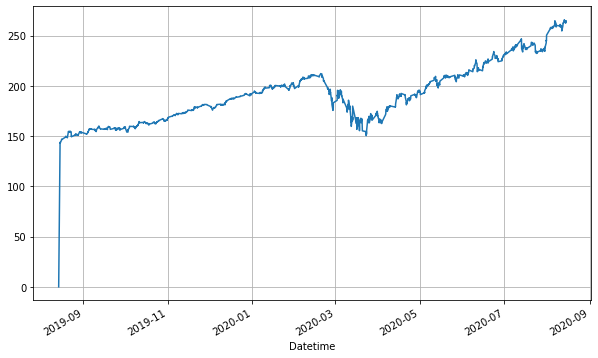

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
propuesta

Datetime
2019-08-14 09:30:00-04:00      0.000000
2019-08-15 09:30:00-04:00    143.766824
2019-08-15 10:30:00-04:00    143.412714
2019-08-15 11:30:00-04:00    143.564603
2019-08-15 12:30:00-04:00    143.602392
                                ...    
2020-08-14 11:30:00-04:00    263.638100
2020-08-14 12:30:00-04:00    264.346087
2020-08-14 13:30:00-04:00    263.886628
2020-08-14 14:30:00-04:00    263.360764
2020-08-14 15:30:00-04:00    264.634040
Length: 1766, dtype: float64

In [23]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

MSFT    0.264862
AAPL    0.264862
TGT     0.264862
ADBE    0.066215
IBM     0.057681
INTC    0.035609
NVDA    0.023838
CSCO    0.014420
GLOB    0.004709
QCOM    0.002649
Name: MinCVaR, dtype: float64